In [1]:
import pickle
import numpy as np
import cv2
from matplotlib import pyplot as plt
import math
#загрузка массива данных для обучения моделей
filename='data'

imall,yy = pickle.load(open(filename, 'rb'))
# масштабирование величины яркости пикселей из формы 0-255 в форму 0 - 1
imall=imall/255.0
yy.shape

(1042870,)

0.0

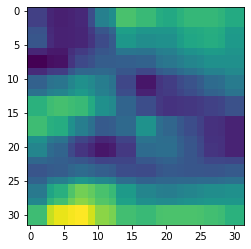

In [2]:
#отрисовка элемената b и вывод значения сфера или нет
b=450121
plt.imshow(np.reshape(imall[b,:],(32,32)))
yy[b]

In [3]:
#разбивка массива анных на тестовую 2% и обучающую выборки 98%
from sklearn.model_selection import  train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(imall,yy,random_state=0,test_size=0.02)


#преобразование формы массива для ее соответствия функции fit керас
Xtrain=np.reshape(Xtrain,(len(Xtrain),32,32,1)).astype('float32')
ytrain=np.reshape(ytrain,(len(ytrain),1)).astype('float32')
Xtest=np.reshape(Xtest,(len(Xtest),32,32,1)).astype('float32')
ytest=np.reshape(ytest,(len(ytest),1)).astype('float32')

ytr1=np.zeros((len(ytrain),1))
ytr2=np.zeros((len(ytrain),1))
ytr1[ytrain==0]=1
ytr1[ytrain==1]=1
ytr=np.hstack((ytr1,ytr2))

yte1=np.zeros((len(ytest),1))
yte2=np.zeros((len(ytest),1))
yte1[ytest==0]=1
yte1[ytest==1]=1
yte=np.hstack((yte1,yte2))

In [4]:
#загрузка керас и тензорфлоу
import os
from sklearn.metrics import classification_report
import numpy as np
import tensorflow as tf
import cv2
import os
import math
import random
import pickle
#keras import and windows InteractiveSession bug fix
from tensorflow.keras.optimizers import SGD,schedules
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras.models import load_model
from tensorflow.keras import metrics as ms
from tensorflow.keras import  Model
from tensorflow.keras.layers import Input,Conv2D, Concatenate, MaxPooling2D,Activation,concatenate,AveragePooling2D,GlobalAveragePooling2D
from tensorflow.keras.layers import UpSampling2D, Dropout, BatchNormalization,Flatten,Dense,Reshape

import tensorflow.keras.backend as K


config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Concatenate, MaxPooling2D,Conv2DTranspose,Input
from tensorflow.keras.layers import UpSampling2D, Dropout, BatchNormalization

In [5]:
from tensorflow.keras.models import load_model
#обучение 7 разных моделей с кратно увеличивающимся количеством конволюционных слоев
dim=1
modelhs=[]
for i in range(7): #7
    print(dim)
    model = tf.keras.Sequential()
    model.add(Conv2D(dim, kernel_size=(3,3), padding='same', input_shape=(32, 32, 1), activation='elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(dim*2, (3,3), padding='same', activation='elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(dim*4, (3,3), padding='same', activation='elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(dim*8, (3,3), padding='same', activation='elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=opt,
        loss='binary_crossentropy',
        metrics=['accuracy'])


    class_weights = {0: 1.,
                    1: 15.8}


    model.summary()
    # train the network
    H=model.fit(Xtrain, ytrain, epochs=250, validation_data=(Xtest, ytest),class_weight =class_weights, verbose=1,shuffle = True, batch_size=1000)
    model.save('modelwide'+str(dim), overwrite=True)
    #формирование массива с историей обучения моделей
    modelhs.append(dim)
    modelhs.append(H.history['loss'])
    modelhs.append(H.history["val_loss"])
    modelhs.append(H.history["accuracy"])
    modelhs.append(H.history["val_accuracy"])
    dim=dim*2
    


1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 1)         10        
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 1)        4         
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 1)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 1)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 2)         20        
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 2)       

Epoch 34/250
1023/1023 [==============================] - 12s 11ms/step - loss: 0.4886 - accuracy: 0.8958 - val_loss: 0.2458 - val_accuracy: 0.9078
Epoch 35/250
1023/1023 [==============================] - 12s 11ms/step - loss: 0.4873 - accuracy: 0.8973 - val_loss: 0.2573 - val_accuracy: 0.9014
Epoch 36/250
1023/1023 [==============================] - 12s 11ms/step - loss: 0.4852 - accuracy: 0.8973 - val_loss: 0.2443 - val_accuracy: 0.9087
Epoch 37/250
1023/1023 [==============================] - 12s 11ms/step - loss: 0.4831 - accuracy: 0.8980 - val_loss: 0.2529 - val_accuracy: 0.9039
Epoch 38/250
1023/1023 [==============================] - 12s 11ms/step - loss: 0.4826 - accuracy: 0.8981 - val_loss: 0.2380 - val_accuracy: 0.9112
Epoch 39/250
1023/1023 [==============================] - 12s 11ms/step - loss: 0.4845 - accuracy: 0.8980 - val_loss: 0.2429 - val_accuracy: 0.9091
Epoch 40/250
1023/1023 [==============================] - 12s 11ms/step - loss: 0.4804 - accuracy: 0.8988 - val_

1023/1023 [==============================] - 11s 11ms/step - loss: 0.4296 - accuracy: 0.9111 - val_loss: 0.2065 - val_accuracy: 0.9219
Epoch 145/250
1023/1023 [==============================] - 11s 11ms/step - loss: 0.4275 - accuracy: 0.9115 - val_loss: 0.1864 - val_accuracy: 0.9306
Epoch 146/250
1023/1023 [==============================] - 11s 11ms/step - loss: 0.4276 - accuracy: 0.9112 - val_loss: 0.1974 - val_accuracy: 0.9262
Epoch 147/250
1023/1023 [==============================] - 11s 11ms/step - loss: 0.4261 - accuracy: 0.9121 - val_loss: 0.1918 - val_accuracy: 0.9283
Epoch 148/250
1023/1023 [==============================] - 11s 11ms/step - loss: 0.4298 - accuracy: 0.9115 - val_loss: 0.2102 - val_accuracy: 0.9208
Epoch 149/250
1023/1023 [==============================] - 11s 11ms/step - loss: 0.4295 - accuracy: 0.9112 - val_loss: 0.2126 - val_accuracy: 0.9199
Epoch 150/250
1023/1023 [==============================] - 11s 11ms/step - loss: 0.4274 - accuracy: 0.9112 - val_loss: 0

1023/1023 [==============================] - 11s 11ms/step - loss: 0.4134 - accuracy: 0.9142 - val_loss: 0.1830 - val_accuracy: 0.9304
Epoch 200/250
1023/1023 [==============================] - 11s 11ms/step - loss: 0.4127 - accuracy: 0.9137 - val_loss: 0.2096 - val_accuracy: 0.9198
Epoch 201/250
1023/1023 [==============================] - 11s 11ms/step - loss: 0.4114 - accuracy: 0.9145 - val_loss: 0.2058 - val_accuracy: 0.9224
Epoch 202/250
1023/1023 [==============================] - 11s 11ms/step - loss: 0.4115 - accuracy: 0.9150 - val_loss: 0.2088 - val_accuracy: 0.9200
Epoch 203/250
1023/1023 [==============================] - 11s 11ms/step - loss: 0.4109 - accuracy: 0.9148 - val_loss: 0.2007 - val_accuracy: 0.9235
Epoch 204/250
1023/1023 [==============================] - 11s 11ms/step - loss: 0.4134 - accuracy: 0.9142 - val_loss: 0.1985 - val_accuracy: 0.9241
Epoch 205/250
1023/1023 [==============================] - 11s 11ms/step - loss: 0.4104 - accuracy: 0.9151 - val_loss: 0

INFO:tensorflow:Assets written to: modelwide1\assets


INFO:tensorflow:Assets written to: modelwide1\assets


2
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 2)         20        
                                                                 
 batch_normalization_4 (Batc  (None, 32, 32, 2)        8         
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 2)        0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 16, 16, 2)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 4)         76        
                                                                 
 batch_normalization_5 (Batc  (None, 16, 16, 4)     

Epoch 34/250
1023/1023 [==============================] - 13s 13ms/step - loss: 0.2789 - accuracy: 0.9492 - val_loss: 0.1260 - val_accuracy: 0.9556
Epoch 35/250
1023/1023 [==============================] - 13s 13ms/step - loss: 0.2748 - accuracy: 0.9500 - val_loss: 0.1160 - val_accuracy: 0.9597
Epoch 36/250
1023/1023 [==============================] - 13s 13ms/step - loss: 0.2756 - accuracy: 0.9495 - val_loss: 0.1012 - val_accuracy: 0.9647
Epoch 37/250
1023/1023 [==============================] - 13s 13ms/step - loss: 0.2714 - accuracy: 0.9509 - val_loss: 0.1111 - val_accuracy: 0.9626
Epoch 38/250
1023/1023 [==============================] - 13s 13ms/step - loss: 0.2727 - accuracy: 0.9509 - val_loss: 0.1079 - val_accuracy: 0.9621
Epoch 39/250
1023/1023 [==============================] - 13s 13ms/step - loss: 0.2703 - accuracy: 0.9513 - val_loss: 0.1108 - val_accuracy: 0.9621
Epoch 40/250
1023/1023 [==============================] - 13s 13ms/step - loss: 0.2667 - accuracy: 0.9518 - val_

1023/1023 [==============================] - 13s 13ms/step - loss: 0.1849 - accuracy: 0.9683 - val_loss: 0.0654 - val_accuracy: 0.9799
Epoch 145/250
1023/1023 [==============================] - 13s 13ms/step - loss: 0.1850 - accuracy: 0.9678 - val_loss: 0.0748 - val_accuracy: 0.9762
Epoch 146/250
1023/1023 [==============================] - 13s 13ms/step - loss: 0.1846 - accuracy: 0.9679 - val_loss: 0.0641 - val_accuracy: 0.9796
Epoch 147/250
1023/1023 [==============================] - 13s 13ms/step - loss: 0.1856 - accuracy: 0.9677 - val_loss: 0.0723 - val_accuracy: 0.9773
Epoch 148/250
1023/1023 [==============================] - 13s 13ms/step - loss: 0.1856 - accuracy: 0.9679 - val_loss: 0.0628 - val_accuracy: 0.9801
Epoch 149/250
1023/1023 [==============================] - 13s 13ms/step - loss: 0.1868 - accuracy: 0.9674 - val_loss: 0.0655 - val_accuracy: 0.9796
Epoch 150/250
1023/1023 [==============================] - 13s 13ms/step - loss: 0.1812 - accuracy: 0.9683 - val_loss: 0

1023/1023 [==============================] - 13s 13ms/step - loss: 0.1775 - accuracy: 0.9691 - val_loss: 0.0689 - val_accuracy: 0.9777
Epoch 200/250
1023/1023 [==============================] - 13s 13ms/step - loss: 0.1766 - accuracy: 0.9691 - val_loss: 0.0592 - val_accuracy: 0.9812
Epoch 201/250
1023/1023 [==============================] - 13s 13ms/step - loss: 0.1773 - accuracy: 0.9690 - val_loss: 0.0662 - val_accuracy: 0.9782
Epoch 202/250
1023/1023 [==============================] - 13s 13ms/step - loss: 0.1763 - accuracy: 0.9691 - val_loss: 0.0684 - val_accuracy: 0.9774
Epoch 203/250
1023/1023 [==============================] - 13s 13ms/step - loss: 0.1766 - accuracy: 0.9692 - val_loss: 0.0662 - val_accuracy: 0.9783
Epoch 204/250
1023/1023 [==============================] - 13s 13ms/step - loss: 0.1759 - accuracy: 0.9687 - val_loss: 0.0590 - val_accuracy: 0.9813
Epoch 205/250
1023/1023 [==============================] - 13s 13ms/step - loss: 0.1764 - accuracy: 0.9695 - val_loss: 0

INFO:tensorflow:Assets written to: modelwide2\assets


INFO:tensorflow:Assets written to: modelwide2\assets


4
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 4)         40        
                                                                 
 batch_normalization_8 (Batc  (None, 32, 32, 4)        16        
 hNormalization)                                                 
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 16, 16, 4)        0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 16, 16, 4)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 8)         296       
                                                                 
 batch_normalization_9 (Batc  (None, 16, 16, 8)     

Epoch 34/250
1023/1023 [==============================] - 15s 15ms/step - loss: 0.1431 - accuracy: 0.9770 - val_loss: 0.0523 - val_accuracy: 0.9846
Epoch 35/250
1023/1023 [==============================] - 15s 15ms/step - loss: 0.1397 - accuracy: 0.9775 - val_loss: 0.0671 - val_accuracy: 0.9808
Epoch 36/250
1023/1023 [==============================] - 15s 15ms/step - loss: 0.1379 - accuracy: 0.9779 - val_loss: 0.0449 - val_accuracy: 0.9863
Epoch 37/250
1023/1023 [==============================] - 15s 15ms/step - loss: 0.1345 - accuracy: 0.9784 - val_loss: 0.0642 - val_accuracy: 0.9812
Epoch 38/250
1023/1023 [==============================] - 15s 15ms/step - loss: 0.1344 - accuracy: 0.9785 - val_loss: 0.0675 - val_accuracy: 0.9794
Epoch 39/250
1023/1023 [==============================] - 15s 15ms/step - loss: 0.1333 - accuracy: 0.9785 - val_loss: 0.0656 - val_accuracy: 0.9809
Epoch 40/250
1023/1023 [==============================] - 15s 15ms/step - loss: 0.1298 - accuracy: 0.9793 - val_

1023/1023 [==============================] - 15s 15ms/step - loss: 0.0786 - accuracy: 0.9870 - val_loss: 0.0616 - val_accuracy: 0.9817
Epoch 145/250
1023/1023 [==============================] - 15s 15ms/step - loss: 0.0780 - accuracy: 0.9870 - val_loss: 0.0309 - val_accuracy: 0.9906
Epoch 146/250
1023/1023 [==============================] - 15s 15ms/step - loss: 0.0776 - accuracy: 0.9870 - val_loss: 0.0211 - val_accuracy: 0.9928
Epoch 147/250
1023/1023 [==============================] - 15s 15ms/step - loss: 0.0767 - accuracy: 0.9873 - val_loss: 0.0642 - val_accuracy: 0.9817
Epoch 148/250
1023/1023 [==============================] - 15s 15ms/step - loss: 0.0775 - accuracy: 0.9873 - val_loss: 0.0240 - val_accuracy: 0.9921
Epoch 149/250
1023/1023 [==============================] - 15s 15ms/step - loss: 0.0765 - accuracy: 0.9874 - val_loss: 0.0285 - val_accuracy: 0.9912
Epoch 150/250
1023/1023 [==============================] - 15s 15ms/step - loss: 0.0765 - accuracy: 0.9873 - val_loss: 0

1023/1023 [==============================] - 15s 15ms/step - loss: 0.0719 - accuracy: 0.9881 - val_loss: 0.0198 - val_accuracy: 0.9931
Epoch 200/250
1023/1023 [==============================] - 15s 15ms/step - loss: 0.0691 - accuracy: 0.9883 - val_loss: 0.0218 - val_accuracy: 0.9929
Epoch 201/250
1023/1023 [==============================] - 15s 14ms/step - loss: 0.0700 - accuracy: 0.9883 - val_loss: 0.0216 - val_accuracy: 0.9926
Epoch 202/250
1023/1023 [==============================] - 15s 14ms/step - loss: 0.0708 - accuracy: 0.9882 - val_loss: 0.0181 - val_accuracy: 0.9938
Epoch 203/250
1023/1023 [==============================] - 15s 15ms/step - loss: 0.0700 - accuracy: 0.9882 - val_loss: 0.0580 - val_accuracy: 0.9843
Epoch 204/250
1023/1023 [==============================] - 15s 14ms/step - loss: 0.0709 - accuracy: 0.9885 - val_loss: 0.0240 - val_accuracy: 0.9923
Epoch 205/250
1023/1023 [==============================] - 15s 15ms/step - loss: 0.0678 - accuracy: 0.9887 - val_loss: 0

INFO:tensorflow:Assets written to: modelwide4\assets


INFO:tensorflow:Assets written to: modelwide4\assets


8
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 8)         80        
                                                                 
 batch_normalization_12 (Bat  (None, 32, 32, 8)        32        
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 16, 16, 8)        0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 16, 16, 8)         0         
                                                                 
 conv2d_13 (Conv2D)          (None, 16, 16, 16)        1168      
                                                                 
 batch_normalization_13 (Bat  (None, 16, 16, 16)    

Epoch 34/250
1023/1023 [==============================] - 19s 18ms/step - loss: 0.0669 - accuracy: 0.9889 - val_loss: 0.0269 - val_accuracy: 0.9916
Epoch 35/250
1023/1023 [==============================] - 19s 18ms/step - loss: 0.0650 - accuracy: 0.9893 - val_loss: 0.0575 - val_accuracy: 0.9828
Epoch 36/250
1023/1023 [==============================] - 19s 18ms/step - loss: 0.0656 - accuracy: 0.9888 - val_loss: 0.0239 - val_accuracy: 0.9923
Epoch 37/250
1023/1023 [==============================] - 19s 18ms/step - loss: 0.0648 - accuracy: 0.9892 - val_loss: 0.0389 - val_accuracy: 0.9888
Epoch 38/250
1023/1023 [==============================] - 19s 18ms/step - loss: 0.0630 - accuracy: 0.9894 - val_loss: 0.0485 - val_accuracy: 0.9851
Epoch 39/250
1023/1023 [==============================] - 19s 18ms/step - loss: 0.0620 - accuracy: 0.9896 - val_loss: 0.0218 - val_accuracy: 0.9930
Epoch 40/250
1023/1023 [==============================] - 19s 18ms/step - loss: 0.0615 - accuracy: 0.9895 - val_

1023/1023 [==============================] - 19s 18ms/step - loss: 0.0309 - accuracy: 0.9944 - val_loss: 0.0133 - val_accuracy: 0.9955
Epoch 145/250
1023/1023 [==============================] - 19s 18ms/step - loss: 0.0297 - accuracy: 0.9946 - val_loss: 0.0131 - val_accuracy: 0.9957
Epoch 146/250
1023/1023 [==============================] - 19s 18ms/step - loss: 0.0304 - accuracy: 0.9946 - val_loss: 0.0164 - val_accuracy: 0.9947
Epoch 147/250
1023/1023 [==============================] - 19s 18ms/step - loss: 0.0294 - accuracy: 0.9947 - val_loss: 0.0117 - val_accuracy: 0.9962
Epoch 148/250
1023/1023 [==============================] - 19s 18ms/step - loss: 0.0295 - accuracy: 0.9947 - val_loss: 0.0185 - val_accuracy: 0.9941
Epoch 149/250
1023/1023 [==============================] - 19s 18ms/step - loss: 0.0291 - accuracy: 0.9948 - val_loss: 0.0076 - val_accuracy: 0.9977
Epoch 150/250
1023/1023 [==============================] - 19s 18ms/step - loss: 0.0286 - accuracy: 0.9948 - val_loss: 0

1023/1023 [==============================] - 19s 18ms/step - loss: 0.0256 - accuracy: 0.9953 - val_loss: 0.0090 - val_accuracy: 0.9970
Epoch 200/250
1023/1023 [==============================] - 19s 18ms/step - loss: 0.0256 - accuracy: 0.9954 - val_loss: 0.0083 - val_accuracy: 0.9973
Epoch 201/250
1023/1023 [==============================] - 19s 18ms/step - loss: 0.0257 - accuracy: 0.9953 - val_loss: 0.0087 - val_accuracy: 0.9969
Epoch 202/250
1023/1023 [==============================] - 19s 18ms/step - loss: 0.0247 - accuracy: 0.9953 - val_loss: 0.0076 - val_accuracy: 0.9975
Epoch 203/250
1023/1023 [==============================] - 19s 18ms/step - loss: 0.0252 - accuracy: 0.9953 - val_loss: 0.0127 - val_accuracy: 0.9959
Epoch 204/250
1023/1023 [==============================] - 19s 18ms/step - loss: 0.0258 - accuracy: 0.9953 - val_loss: 0.0129 - val_accuracy: 0.9958
Epoch 205/250
1023/1023 [==============================] - 19s 18ms/step - loss: 0.0255 - accuracy: 0.9954 - val_loss: 0

INFO:tensorflow:Assets written to: modelwide8\assets


INFO:tensorflow:Assets written to: modelwide8\assets


16
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 32, 32, 16)        160       
                                                                 
 batch_normalization_16 (Bat  (None, 32, 32, 16)       64        
 chNormalization)                                                
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 16, 16, 16)       0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 16, 16, 16)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 16, 16, 32)        4640      
                                                                 
 batch_normalization_17 (Bat  (None, 16, 16, 32)   

Epoch 34/250
1023/1023 [==============================] - 28s 28ms/step - loss: 0.0262 - accuracy: 0.9954 - val_loss: 0.0086 - val_accuracy: 0.9969
Epoch 35/250
1023/1023 [==============================] - 28s 28ms/step - loss: 0.0253 - accuracy: 0.9956 - val_loss: 0.0071 - val_accuracy: 0.9973
Epoch 36/250
1023/1023 [==============================] - 28s 28ms/step - loss: 0.0252 - accuracy: 0.9956 - val_loss: 0.0371 - val_accuracy: 0.9875
Epoch 37/250
1023/1023 [==============================] - 28s 28ms/step - loss: 0.0243 - accuracy: 0.9958 - val_loss: 0.0852 - val_accuracy: 0.9670
Epoch 38/250
1023/1023 [==============================] - 28s 28ms/step - loss: 0.0234 - accuracy: 0.9959 - val_loss: 0.0211 - val_accuracy: 0.9926
Epoch 39/250
1023/1023 [==============================] - 28s 28ms/step - loss: 0.0235 - accuracy: 0.9959 - val_loss: 0.0070 - val_accuracy: 0.9979
Epoch 40/250
1023/1023 [==============================] - 28s 28ms/step - loss: 0.0231 - accuracy: 0.9959 - val_

1023/1023 [==============================] - 28s 28ms/step - loss: 0.0093 - accuracy: 0.9982 - val_loss: 0.0175 - val_accuracy: 0.9943
Epoch 145/250
1023/1023 [==============================] - 28s 28ms/step - loss: 0.0083 - accuracy: 0.9984 - val_loss: 0.0040 - val_accuracy: 0.9985
Epoch 146/250
1023/1023 [==============================] - 28s 28ms/step - loss: 0.0093 - accuracy: 0.9982 - val_loss: 0.0028 - val_accuracy: 0.9990
Epoch 147/250
1023/1023 [==============================] - 28s 28ms/step - loss: 0.0088 - accuracy: 0.9984 - val_loss: 0.0035 - val_accuracy: 0.9987
Epoch 148/250
1023/1023 [==============================] - 28s 28ms/step - loss: 0.0088 - accuracy: 0.9983 - val_loss: 0.0032 - val_accuracy: 0.9988
Epoch 149/250
1023/1023 [==============================] - 28s 28ms/step - loss: 0.0089 - accuracy: 0.9983 - val_loss: 0.0050 - val_accuracy: 0.9982
Epoch 150/250
1023/1023 [==============================] - 28s 28ms/step - loss: 0.0084 - accuracy: 0.9985 - val_loss: 0

1023/1023 [==============================] - 28s 28ms/step - loss: 0.0069 - accuracy: 0.9987 - val_loss: 0.0038 - val_accuracy: 0.9987
Epoch 200/250
1023/1023 [==============================] - 28s 28ms/step - loss: 0.0073 - accuracy: 0.9986 - val_loss: 0.0031 - val_accuracy: 0.9988
Epoch 201/250
1023/1023 [==============================] - 28s 28ms/step - loss: 0.0073 - accuracy: 0.9986 - val_loss: 0.0086 - val_accuracy: 0.9969
Epoch 202/250
1023/1023 [==============================] - 28s 28ms/step - loss: 0.0077 - accuracy: 0.9985 - val_loss: 0.0015 - val_accuracy: 0.9994
Epoch 203/250
1023/1023 [==============================] - 28s 28ms/step - loss: 0.0071 - accuracy: 0.9986 - val_loss: 0.0032 - val_accuracy: 0.9989
Epoch 204/250
1023/1023 [==============================] - 30s 29ms/step - loss: 0.0084 - accuracy: 0.9985 - val_loss: 0.0023 - val_accuracy: 0.9990
Epoch 205/250
1023/1023 [==============================] - 29s 28ms/step - loss: 0.0067 - accuracy: 0.9987 - val_loss: 0

INFO:tensorflow:Assets written to: modelwide16\assets


INFO:tensorflow:Assets written to: modelwide16\assets


32
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 32, 32, 32)        320       
                                                                 
 batch_normalization_20 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization_21 (Bat  (None, 16, 16, 64)   

Epoch 34/250
1023/1023 [==============================] - 49s 48ms/step - loss: 0.0125 - accuracy: 0.9978 - val_loss: 0.0063 - val_accuracy: 0.9982
Epoch 35/250
1023/1023 [==============================] - 49s 48ms/step - loss: 0.0124 - accuracy: 0.9978 - val_loss: 0.0173 - val_accuracy: 0.9945
Epoch 36/250
1023/1023 [==============================] - 49s 48ms/step - loss: 0.0117 - accuracy: 0.9978 - val_loss: 0.0040 - val_accuracy: 0.9988
Epoch 37/250
1023/1023 [==============================] - 49s 48ms/step - loss: 0.0111 - accuracy: 0.9981 - val_loss: 0.0034 - val_accuracy: 0.9989
Epoch 38/250
1023/1023 [==============================] - 49s 48ms/step - loss: 0.0114 - accuracy: 0.9981 - val_loss: 0.0081 - val_accuracy: 0.9972
Epoch 39/250
1023/1023 [==============================] - 49s 48ms/step - loss: 0.0107 - accuracy: 0.9980 - val_loss: 0.3904 - val_accuracy: 0.8941
Epoch 40/250
1023/1023 [==============================] - 49s 48ms/step - loss: 0.0111 - accuracy: 0.9980 - val_

1023/1023 [==============================] - 49s 48ms/step - loss: 0.0034 - accuracy: 0.9994 - val_loss: 8.2313e-04 - val_accuracy: 0.9998
Epoch 144/250
1023/1023 [==============================] - 49s 48ms/step - loss: 0.0030 - accuracy: 0.9994 - val_loss: 9.9812e-04 - val_accuracy: 0.9996
Epoch 145/250
1023/1023 [==============================] - 49s 48ms/step - loss: 0.0033 - accuracy: 0.9994 - val_loss: 3.3760e-04 - val_accuracy: 1.0000
Epoch 146/250
1023/1023 [==============================] - 49s 48ms/step - loss: 0.0039 - accuracy: 0.9993 - val_loss: 4.7663e-04 - val_accuracy: 0.9998
Epoch 147/250
1023/1023 [==============================] - 49s 48ms/step - loss: 0.0027 - accuracy: 0.9995 - val_loss: 8.3148e-04 - val_accuracy: 0.9997
Epoch 148/250
1023/1023 [==============================] - 49s 48ms/step - loss: 0.0031 - accuracy: 0.9994 - val_loss: 3.4560e-04 - val_accuracy: 0.9999
Epoch 149/250
1023/1023 [==============================] - 49s 48ms/step - loss: 0.0035 - accura

INFO:tensorflow:Assets written to: modelwide32\assets


INFO:tensorflow:Assets written to: modelwide32\assets


64
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 32, 32, 64)        640       
                                                                 
 batch_normalization_24 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 16, 16, 64)        0         
                                                                 
 conv2d_25 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 batch_normalization_25 (Bat  (None, 16, 16, 128)  

Epoch 88/250
1023/1023 [==============================] - 97s 95ms/step - loss: 0.0027 - accuracy: 0.9995 - val_loss: 5.0418e-04 - val_accuracy: 0.9998
Epoch 89/250
1023/1023 [==============================] - 97s 95ms/step - loss: 0.0025 - accuracy: 0.9995 - val_loss: 0.1641 - val_accuracy: 0.9579
Epoch 90/250
1023/1023 [==============================] - 97s 95ms/step - loss: 0.0024 - accuracy: 0.9995 - val_loss: 9.2456e-04 - val_accuracy: 0.9996
Epoch 91/250
1023/1023 [==============================] - 97s 95ms/step - loss: 0.0034 - accuracy: 0.9994 - val_loss: 0.0032 - val_accuracy: 0.9986
Epoch 92/250
1023/1023 [==============================] - 97s 95ms/step - loss: 0.0021 - accuracy: 0.9996 - val_loss: 0.0162 - val_accuracy: 0.9949
Epoch 93/250
1023/1023 [==============================] - 97s 95ms/step - loss: 0.0024 - accuracy: 0.9996 - val_loss: 1.5026e-04 - val_accuracy: 0.9999
Epoch 94/250
1023/1023 [==============================] - 97s 95ms/step - loss: 0.0027 - accuracy: 0

1023/1023 [==============================] - 97s 95ms/step - loss: 0.0017 - accuracy: 0.9997 - val_loss: 1.9491e-04 - val_accuracy: 0.9999
Epoch 197/250
1023/1023 [==============================] - 97s 95ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 3.6764e-04 - val_accuracy: 0.9999
Epoch 198/250
1023/1023 [==============================] - 97s 95ms/step - loss: 0.0017 - accuracy: 0.9997 - val_loss: 0.0013 - val_accuracy: 0.9995
Epoch 199/250
1023/1023 [==============================] - 97s 95ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 3.7661e-04 - val_accuracy: 0.9999
Epoch 200/250
1023/1023 [==============================] - 97s 95ms/step - loss: 0.0017 - accuracy: 0.9997 - val_loss: 2.0791e-04 - val_accuracy: 0.9999
Epoch 201/250
1023/1023 [==============================] - 97s 95ms/step - loss: 7.2991e-04 - accuracy: 0.9999 - val_loss: 3.1928e-04 - val_accuracy: 0.9998
Epoch 202/250
1023/1023 [==============================] - 97s 95ms/step - loss: 0.0015 - accura

Epoch 250/250
1023/1023 [==============================] - 97s 95ms/step - loss: 7.9433e-04 - accuracy: 0.9999 - val_loss: 2.2701e-04 - val_accuracy: 0.9999


INFO:tensorflow:Assets written to: modelwide64\assets


INFO:tensorflow:Assets written to: modelwide64\assets


In [6]:
#сохранение результатов обучения
filename='modellearn_data'
pickle.dump(modelhs, open(filename, 'wb'))